# Maximizing the ELBO

Review of terminology:

* p(z) = prior
* q(z|x) = encoding distribution
* p(x|z) = decoding distribution

$$\begin{align}
\log p(x) & \geq E_{Z~q(z|x}[-\log q(z|x) + \log p(x,z)] \\
&= -\text{KL} [q(z|x) || p(z)] + E_{z~q(z|x)}[\log p(x|z]
\end{align}$$

The loss that we estimate and optimize is the ELBO, which is maximized. On the left end side we have the log evidence or log `p(x)` and on the right side we have the ELBO, with the KL divergence between the posterior and the prior as well as the expected reconstruction loss.

In [16]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfl = tfp.layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Reshape
import matplotlib.pyplot as plt
import numpy as np

In [21]:
# Import Fashion MNIST, make it a Tensorflow dataset

(x_train, _), (x_test, _) = tf.keras.datasets.fashion_mnist.load_data()
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255
example_x = x_test[:16]

batch_size = 64
x_train = tf.data.Dataset.from_tensor_slices(x_train).batch(batch_size)

In [22]:
# Define the encoding distribution, q(z|x)

latent_size = 2
event_shape=(28,28)

encoder = Sequential([
    Flatten(input_shape=event_shape),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(2*latent_size),
    tfl.DistributionLambda(
        lambda t: tfd.MultivariateNormalDiag(
            loc=t[..., :latent_size],
            scale_diag=tf.math.exp(t[..., latent_size:])))
])

In [23]:
# Pass an example image through the network - should return a batch of MultivariateNormalDiag

encoder(example_x)

<tfp.distributions.MultivariateNormalDiag 'sequential_1_distribution_lambda_1_MultivariateNormalDiag' batch_shape=[16] event_shape=[2] dtype=float32>

In [25]:
# Define the decoding distribution, p(x|z)

decoder = Sequential([
    Dense(32, activation='relu'),
    Dense(64, activation='relu'),
    Dense(128, activation='relu'),
    Dense(256, activation='relu'),
    Dense(tfl.IndependentBernoulli.params_size(event_shape)),
    tfl.IndependentBernoulli(event_shape)
])

In [26]:
# Pass a batch of examples to the decoder

decoder(tf.random.normal([16, latent_size]))

<tfp.distributions.Independent 'sequential_2_independent_bernoulli_IndependentBernoulli_Independentsequential_2_independent_bernoulli_IndependentBernoulli_Bernoulli' batch_shape=[16] event_shape=[28, 28] dtype=float32>

In [27]:
# Define the prior, p(z) - a standard bivariate Gaussian

prior = tfd.MultivariateNormalDiag(loc=tf.zeros(latent_size))

The loss function that we need to estimate is

$$\begin{align}
- ELBO = \text{KL} [q(z|x) || p(z)] -E_{z~q(z|x)}[\log p(x|z]
\end{align}$$

where $x = (x_1, x_2, ..., x_n$ refers to all observations, $z = (z_1, z_2, ..., z_n)$ refers to the corresponding latent variables.

Assumed independence of examples implies that we can write this as 

$$\begin{align}
\sum_j \text{KL} [q(z_j|x_j) || p(z_j)] -E_{z_j~q(z_j|x_j)}[\log p(x_j|z_j]
\end{align}$$

Our model will compute the KL divergence analytically, but the second term will be computed using $\log p(x_j| z_j)$ where $z_j$ is a single sample from $q(z_j|x_j)$. This is a Monte Carlo estimate using only 1 sample.

In [28]:
# Specify the loss function, an estimate of the -ELBO

def loss(x, encoding_dist, sampled_decoding_dist, prior):
    return tf.reduce_sum(
        tfd.kl_divergence(encoding_dist, prior) - sampled_decoding_dist.log_prob(x))

In [31]:
# Define a function that returns the loss and its gradients

@tf.function
def get_loss_and_grads(x):
    with tf.GradientTape() as tape:
        encoding_dist = encoder(x)
        sampled_z = encoding_dist.sample()
        sampled_decoding_dist = decoder(sampled_z)
        current_loss = loss(x, encoding_dist, sampled_decoding_dist, prior)
        
    grads = tape.gradient(current_loss,
                         encoder.trainable_variables + decoder.trainable_variables)
    return current_loss, grads

If we want make a lower variance estimate of the reconstruction error, we can draw more than one sampling from each encoding distribution.

In [32]:
# Compile and train the model

num_epochs = 5
opt = tf.keras.optimizers.Adam()
for i in range(num_epochs):
    for train_batch in x_train:
        current_loss, grads = get_loss_and_grads(train_batch)
        opt.apply_gradients(zip(grads, encoder.trainable_variables + decoder.trainable_variables))
        
    print('-ELBO after epoch {}: {:.0f}'.format(i+1, current_loss.numpy()))

-ELBO after epoch 5: 8727


In [34]:
# Connect encoder and decoder, compute a reconstruction

def vae(inputs):
    approx_posterior = encoder(inputs)
    decoding_dist = decoder(approx_posterior.sample())
    return decoding_dist.sample()

example_reconstruction = vae(example_x)

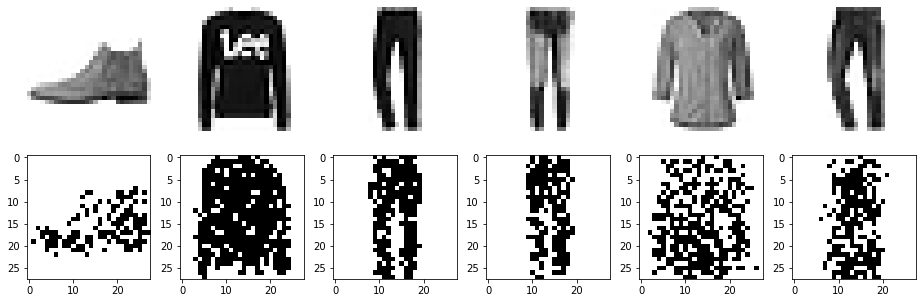

In [35]:
# Plot examples against reconstructions

f, axs = plt.subplots(2, 6, figsize=(16, 5))

for j in range(6):
    axs[0, j].imshow(example_x[j, :, :].squeeze(), cmap='binary')
    axs[1, j].imshow(example_reconstruction[j, :, :], cmap='binary')
    axs[0, j].axis('off')
    axs[0, j].axis('off')

Because the decoding distribution is only over binary values it is quite limited in its ability to produce grey scale images.

In [37]:
# Connect encoder and decoder, compute a reconstruction

def vae(inputs):
    approx_posterior = encoder(inputs)
    decoding_dist = decoder(approx_posterior.sample())
    return decoding_dist.mean()

example_reconstruction = vae(example_x)

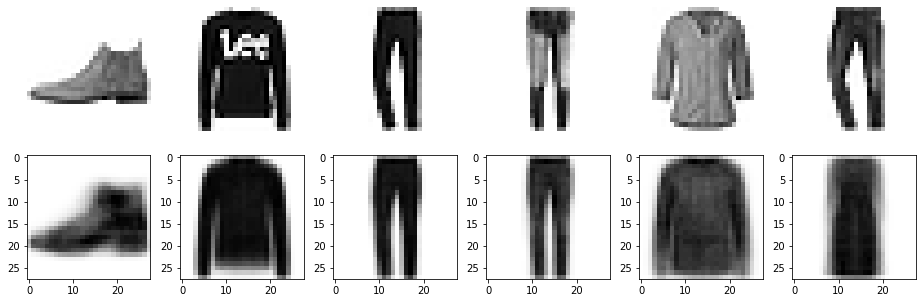

In [38]:
# Plot examples against reconstructions

f, axs = plt.subplots(2, 6, figsize=(16, 5))

for j in range(6):
    axs[0, j].imshow(example_x[j, :, :].squeeze(), cmap='binary')
    axs[1, j].imshow(example_reconstruction[j, :, :], cmap='binary')
    axs[0, j].axis('off')
    axs[0, j].axis('off')

This is possible to achieve by computing the mean of the decoding distribution.

In [40]:
# Generate an example - sample a z value, then sample a reconstruction from p(x|z)

z = prior.sample(6)
generated_x = decoder(z).sample()

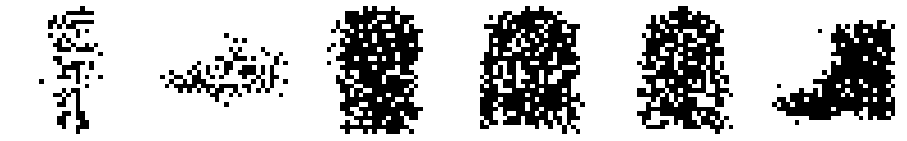

In [41]:
# Display generated x

f, axs = plt.subplots(1, 6, figsize=(16, 5))
for j in range(6):
    axs[j].imshow(generated_x[j, :, :].numpy().squeeze(), cmap='binary')
    axs[j].axis('off')

In [43]:
# Generate an example - sample a z value, then sample a reconstruction from p(x|z)

z = prior.sample(6)
generated_x = decoder(z).mean()

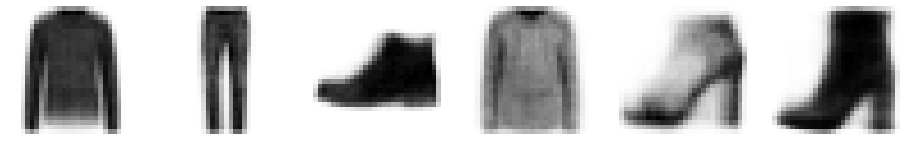

In [44]:
# Display generated x

f, axs = plt.subplots(1, 6, figsize=(16, 5))
for j in range(6):
    axs[j].imshow(generated_x[j, :, :].numpy().squeeze(), cmap='binary')
    axs[j].axis('off')